# Synthèse d’images satellites à partir d’une carte

Synthése d'images satellites réalistes à partir d’une carte grossière en utilisant une méthode de génération d’images conditionnée : `pix2pix`


## Méthodes utilisées
Nous allons implémenter la méthode de Pix2pix qui est un cGAN (Conditionnal Generative Adversarial Networks).
Les GANs sont des modèles génératifs qui apprennent à générer une image de sortie (y) à partir d'un vecteur de bruit (z) G : z → y. Ici nous utilisons un `cGAN`, GAN conditionnel qui produit une image (y) à partir d'une image en input (x) et d'un vecteur de bruit (z) G : {x, z} → y. Ce qui est adapté à notre problème, car on veut générer une image satellite (y) à partir d'une image de carte (x).

Les cGANs, tout comme les GANs, sont composés d'un générateur (le faussaire) et d'un discriminateur (le critique d'art) .
Le `générateur` est entrainé pour produire des images non distinguables des images "réelles", il essaie de tromper le discriminateur. Le `discriminateur` doit réussir à détecter les images "fausses"/générées des images "réelles". Le discriminateur maximise la fonction de cout alors que le générateur la minise, ils jouent à un jeu de MINIMAX.

Le générateur a une architecture de type 'U-Net' et le discriminateur est un Patch-GAN.  
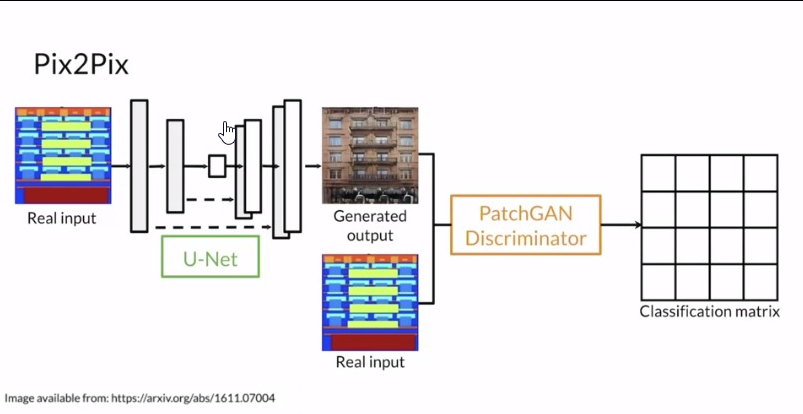


On utilisera `TensorFlow` pour implémenter notre modèle.

## Jeu de données
On va utiliser le jeu de données disponible en ligne sur : http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.
Il est composé de 1096 images pour l'entrainement et 1098 images pour les tests. Ces images de taille (600x1200) correspondent chacune à 2 images : satellite (600x600), et carte (600x600). Le dataset est déjà divisé en dossiers `train` et `val`.

## Code

Pour commencer, il faut installer les packages nécessaires, en particulier :
- tensorflow
- matplotlib

Lancer la ligne ci-dessous, pour installer automatiquement les packages nécessaires.

In [72]:
#!pip install -r requirements.txt

In [73]:
import tensorflow as tf
import os
import pathlib
import time
import datetime
from matplotlib import pyplot as plt
from IPython import display

Constantes:

In [74]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
BUFFER_SIZE = 1000
BATCH_SIZE = 1
OUTPUT_CHANNELS = 3

### Chargement et preprocessing du jeu de données : 

In [75]:
path_to_zip = tf.keras.utils.get_file(
    fname="maps.tar.gz",
    origin='http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz',
    extract=True)

path_to_zip  = pathlib.Path(path_to_zip)

PATH = path_to_zip.parent/"maps"

In [76]:
sample_image = tf.io.read_file(str(PATH / 'train/1.jpg'))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

(600, 1200, 3)


Une image (600x1200) correspond à 2 images : satellite (600x600), et carte (600x600).
il va falloir les couper en 2 et les resizer au format IMG_SIZE = (256,256).

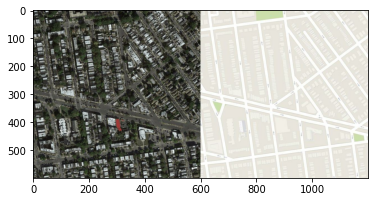

In [77]:
plt.figure()
plt.imshow(sample_image)

In [78]:
def resize(input_image, img_size):
    return tf.image.resize(input_image, [img_size[0],img_size[1]],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

In [79]:
def get_seperated_images(image_file, img_size = IMG_SIZE):
    
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)
    
    # on découpe les images en 2 sur la longueur (width//2)
    w = tf.shape(image)[1]
    w = w // 2
    map_image = image[:, w:]
    sat_image = image[:, :w]
    
    # On convertit ces np.array en tenseurs de float
    map_image = tf.cast(map_image, tf.float32)
    sat_image = tf.cast(sat_image, tf.float32)
    return resize(map_image, img_size), resize(sat_image, img_size)

Testons la fonction de `get_seperated_images`, en affichant les images et leur format respectif.

(256, 256, 3)
(256, 256, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>


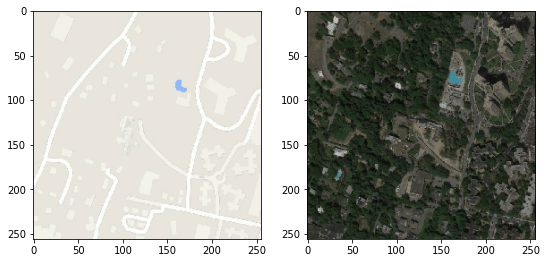

In [80]:
image_map, image_satellite = get_seperated_images(str(PATH / 'train/100.jpg'), IMG_SIZE)
print(image_map.shape)
print(image_satellite.shape)
print(type(image_map))

plt.figure(figsize=(9,7))
plt.subplot(1, 2, 1)
plt.imshow(image_map / 255.0)
plt.subplot(1, 2, 2)
plt.imshow(image_satellite / 255.0)

On applique aux données un "Random jitter" avec la fonction `random_jitter` comme expliqué dans le papier de *Pix2Pix*, cela correspond à reformatter l'image en une taille plus grande 286x286 puis recouper aléatoirement en 256x256 (`random_crop`). On applique aussi un effet miroir aux données ("mirroring" ) : `random_mirroring`.
Ensuite, on rescale pour avoir des pixels compris entre -1 et 1. 

Le preprocessing doit etre effectué sur les images input et output en même temps, pour avoir les mêmes déformations.
Par exemple quand on appelle random_crop ou random_mirroring.

In [81]:
@tf.function()
def random_jitter(input_image, real_image):
    input_image = resize(input_image, (286, 286)) 
    real_image = resize(real_image, (286, 286))
    
    def random_crop(input_image, real_image):
        stacked_image = tf.stack([input_image, real_image], axis=0)
        cropped_image = tf.image.random_crop(stacked_image, 
                                             size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
        return cropped_image[0], cropped_image[1]
    
    return random_crop(input_image, real_image)

def random_mirroring(input_image, real_image):
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)
    return input_image, real_image

def rescaling(image):
    return (image / 127.5) - 1

def load_image_train(image_file):
    input_image, real_image = get_seperated_images(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = random_mirroring(input_image, real_image)
    input_image, real_image = rescaling(input_image), rescaling(real_image)
    return input_image, real_image

def load_image_test(image_file):
    input_image, real_image = get_seperated_images(image_file)
    input_image, real_image = rescaling(input_image), rescaling(real_image)
    return input_image, real_image

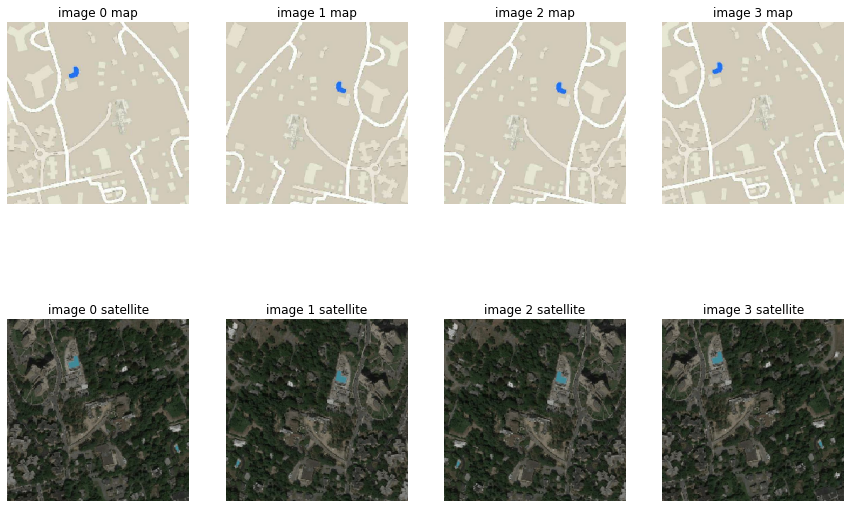

In [82]:
plt.figure(figsize=(15, 10))
for i in range(4):
    input_image, real_image = load_image_train(str(PATH / 'train/100.jpg'))
    plt.subplot(2, 4, i + 1)
    plt.title(f"image {i} map")
    plt.imshow(input_image)
    plt.axis('off')
    plt.subplot(2, 4, i + 5)
    plt.title(f"image {i} satellite")
    plt.imshow(real_image * 0.5 + 0.5)
    plt.axis('off')
plt.show()

In [126]:
train_dataset = tf.data.Dataset.list_files(str(PATH / 'train/*.jpg'))
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.cache()\
                             .shuffle(BUFFER_SIZE)\
                             .batch(BATCH_SIZE)\
                             .prefetch(buffer_size=tf.data.AUTOTUNE)

In [127]:
test_dataset = tf.data.Dataset.list_files(str(PATH / 'val/*.jpg'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.cache()\
                           .batch(BATCH_SIZE)\
                           .prefetch(buffer_size=tf.data.AUTOTUNE)

### Le générateur

Le générateur a une architecture semblable au “U-Net”, c'est un encodeur-décodeur avec quelques particularités :
- des "skip connections" entre couches similaires (mirroires) entre l'encodeur et le décodeur, 
- des couches de convolutions simples avec stride = 2
- chaque bloc est de type (conv, batch normalisation, Relu ou LeakyReLU).

*skip connections* : C'est à dire que chaque couche du décodeur (exceptée la première) contient une entrée qui vient directement de l'encodeur similaire.
Elles sont réalisées grace à la fonction `Concatenate` de keras.

Son architecture est (presque) la suivante :  
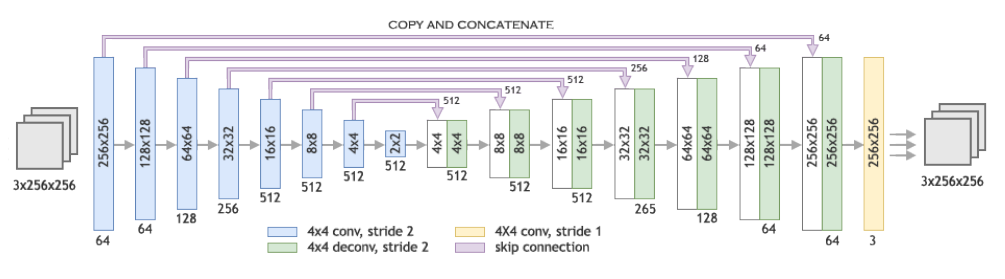

Note :  le nombre de blocs de convolution n'est pas exactement le même que notre modèle Pix2Pix. C'est juste pour avoir une idée de l'architecture.

Selon le papier pix2pix, les architectures sont les suivantes :  
**encodeur**: C64-C128-C256-C512-C512-C512-C512-C512  
**décodeur**: CD512-CD512-CD512-C512-C256-C128-C64  
où :
- Ck bloc Convolution-BatchNorm-(ReLU pour le décodeur, LeakyRelu pour l'encodeur)   avec k filtres
- CDk bloc Convolution-BatchNorm-LeakyRelu avec taux de dropout = 50%

Toutes les convolutions sont des filtres 4x4 avec un stride = 2. Pour le décodeur ce sont des convolutions transposées. Les activations ReLU ou LeakyReLU ont une pente de 0.2.
De plus, après la derniere couche de décodeur on ajoute une convolution pour mapper au nombre de canaux (OUTPUT_CHANNELS) suivi d'une fonction d'activation Tanh.

Un `encoder_block` est un bloc Convolution-BatchNorma-LeakyReLU, avec possibilité de désactiver la normalisation avec `batch_normalization=False`.

In [128]:
def encoder_block(nb_filters_conv, batch_normalization=True):
    conv_2D = tf.keras.Sequential()
    conv_2D.add(tf.keras.layers.Conv2D(nb_filters_conv, 
                                       4, 
                                       strides=2, 
                                       padding='same', 
                                       use_bias=False))
    if batch_normalization :
        conv_2D.add(tf.keras.layers.BatchNormalization())
    conv_2D.add(tf.keras.layers.LeakyReLU())
    return conv_2D

In [86]:
def decoder_block(nb_filters_conv, dropout=True):
    
    conv_2D_T = tf.keras.Sequential([
        tf.keras.layers.Conv2DTranspose(nb_filters_conv, 
                                        4, 
                                        strides=2, 
                                        padding='same', 
                                        use_bias=False),
        tf.keras.layers.BatchNormalization()
    ])
    if dropout:
        conv_2D_T.add(tf.keras.layers.Dropout(0.5))
    conv_2D_T.add(tf.keras.layers.ReLU())
    return conv_2D_T

In [88]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    stored_skips_connections =[]
    
    # début de l'encodage
    x = encoder_block(64, batch_normalization=False)(inputs)
    stored_skips_connections.append(x)
    x = encoder_block(128)(x)  # (64, 64, 128)
    stored_skips_connections.append(x)
    x = encoder_block(256)(x)  # ( 32, 32, 256)
    stored_skips_connections.append(x)
    x = encoder_block(512)(x)  # ( 16, 16, 512)
    stored_skips_connections.append(x)
    x = encoder_block(512)(x)  # ( 8, 8, 512)
    stored_skips_connections.append(x)
    x = encoder_block(512)(x)  # ( 4, 4, 512)
    stored_skips_connections.append(x)
    x = encoder_block(512)(x)  # ( 2, 2, 512)
    stored_skips_connections.append(x)
    x = encoder_block(512)(x)  # ( 1, 1, 512)
    
    # début du décodage
    x = decoder_block(512)(x)  # ( 2, 2, 1024)
    # stored_skips_connections[6] correspond à l'output du dernier encoder de filtre = 512
    x = tf.keras.layers.Concatenate()([x, stored_skips_connections[6]])
    
    x = decoder_block(512)(x)  # ( 4, 4, 1024)
    x = tf.keras.layers.Concatenate()([x, stored_skips_connections[5]])
    
    x = decoder_block(512)(x)  # ( 8, 8, 1024)
    x = tf.keras.layers.Concatenate()([x, stored_skips_connections[4]])
    
    x = decoder_block(512, dropout=False)(x)  # ( 16, 16, 1024)
    x = tf.keras.layers.Concatenate()([x, stored_skips_connections[3]])
    
    x = decoder_block(256, dropout=False)(x)  # ( 32, 32, 512)
    # stored_skips_connections[2] correspond à l'output du dernier encoder de filtre = 256
    x = tf.keras.layers.Concatenate()([x, stored_skips_connections[2]])
    
    x = decoder_block(128, dropout=False)(x)  # ( 64, 64, 256)
    x = tf.keras.layers.Concatenate()([x, stored_skips_connections[1]])
    
    x = decoder_block(64, dropout=False)(x)  # ( 128, 128, 128)
    x = tf.keras.layers.Concatenate()([x, stored_skips_connections[0]])

    outputs = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                              strides=2,
                                              padding='same',
                                              activation='tanh')(x)  # ( 256, 256, 3)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [89]:
generator = Generator()
generator.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_29 (Sequential)     (None, 128, 128, 64  3072        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_30 (Sequential)     (None, 64, 64, 128)  131584      ['sequential_29[0][0]']          
                                                                                            

### Le discriminateur

Le discriminateur a pour but d'identifier les "faux" des images réelles. 
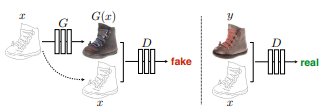  
Le discriminateur est un classifieur convolutif `PatchGAN`, qui pénalise à l'échelle de patch (et non de l'image entière). Dans son implémentation Pix2pix a choisit des patchs de taille `70x70`.

Le discriminateur a deux entrées : l'image d'entrée `image_input` (ici notre carte 2D) et une image target `image_target` (ici notre carte satellite)  qui peut être une image générée ou l'image réelle.

Son architecture est selon le papier *Pix2Pix* : C64-C128-C256-C512.  
Après la dernière couche, on applique une convolution pour mapper à un output à une dimension (0/1) suivi d'une fonction Sigmoid. Notez qu'il n'y a pas de batchNorm appliqué à la première couche C64. Tous les ReLU sont Leaky donc on utilise le `encoder_block` définit plus tôt.

In [90]:
def Discriminator():

    image_input = tf.keras.layers.Input(shape=[256, 256, 3], name='image_input')
    image_target = tf.keras.layers.Input(shape=[256, 256, 3], name='image_target')

    x = tf.keras.layers.concatenate([image_input, image_target])
    x = encoder_block(64, batch_normalization=False)(x)  # ( 128, 128, 64)
    x = encoder_block(128)(x)  # ( 64, 64, 128)
    x = encoder_block(256)(x)  # ( 32, 32, 256)
    x = encoder_block(512)(x) # (16, 16, 512)
    output = tf.keras.layers.Conv2D(1, 4, strides=2, activation='sigmoid')(x)
    return tf.keras.Model(inputs=[image_input, image_target], outputs=output)

In [91]:
discriminator = Discriminator()
discriminator.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 image_target (InputLayer)      [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_16 (Concatenate)   (None, 256, 256, 6)  0           ['image_input[0][0]',            
                                                                  'image_target[0][0]']     

### Générer et afficher les images

On met sur `training=True` pour que le modèle génère une image à partir de l'image donnée en entrée.

In [92]:
def generate_images(model, test_input, test_output):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], test_output[0], prediction[0]]
    title = ['Input Image', 'Output Image', 'Generated Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # conversion des pixels de [-1,1] vers [0, 1]
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')

    plt.show()

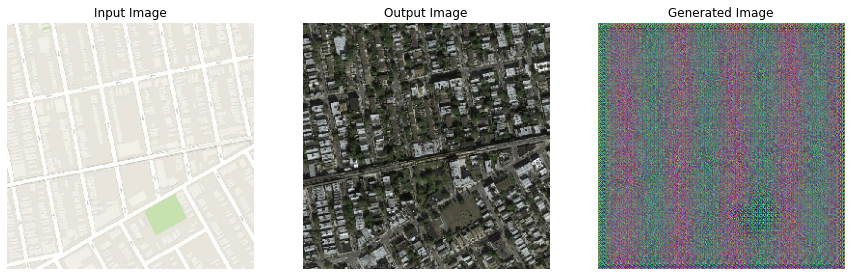

In [93]:
for example_input, example_target in test_dataset.take(1):
    generate_images(generator, example_input, example_target)

### Fonctions de perte

**Fonction de perte du discriminateur** : elle quantifie la capacité du discriminateur à distinguer les vraies images des fausses. Elle est la somme de 2 termes :
- `real_loss` : elle compare les images réelles à un tableau de 1 (1 pour image réelle)
- `fake_loss` : elle compare les fausses images à un tableau de 0 (0 pour image "fake")

In [94]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(real_output), 
                                                     real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy()(tf.zeros_like(fake_output), 
                                                     fake_output)
    return real_loss + fake_loss

**Fonction de perte du générateur**: elle quantifie à quel point le générateur a réussi à tromper le discriminateur. Son but est que les images générées ("fake") soient considérées comme réelles. On introduit aussi une fonction de perte L1 pour que l'image générée soit proche de l'image input ("ground truth").  
Elle est la somme de 2 termes :
- `gen_loss` :  elle compare les images générées considérées comme fausses par le discriminateur à un tableau de 1 (images réelles)
- `LAMBDA * l1_loss`  : la distance entre l'image générée et l'image réelle input doit etre minimisée

Dans le papier *Pix2Pix* LAMBDA est fixé à 100.

In [95]:
LAMBDA = 100

def generator_loss(disc_fake_output, real_output, fake_output):
    gen_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(disc_fake_output), 
                                                    disc_fake_output)
    l1_loss = tf.reduce_mean(tf.abs(real_output - fake_output))
    return gen_loss + LAMBDA * l1_loss


Les paramètres des optimiseurs ci-dessous sont fixés par le papier `Pix2Pix`.

In [96]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, beta_2=0.999)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, beta_2=0.999)

### Training
La boucle d'apprentissage commence avec le générateur qui génère une image à partir de `input_image`. Le discriminateur est ensuite utilisé pour classer les images réelles (tirées de l'ensemble d'apprentissage) et les fausses images (produites par le générateur). La perte est calculée pour chacun de ces modèles, et les gradients sont utilisés pour mettre à jour le générateur et le discriminateur.

In [97]:
# L'annotation `tf.function` permet à la fonction d'être "compilée"
@tf.function
def train_step(input_image, output_image):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_fake_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, output_image], training=True)
        disc_fake_output = discriminator([input_image, gen_fake_output], training=True)

        gen_loss = generator_loss(disc_fake_output, output_image, gen_fake_output)
        disc_loss = discriminator_loss(disc_real_output, disc_fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, 
                                               generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, 
                                                    discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, 
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, 
                                                discriminator.trainable_variables))

On crée des checkpoints, pour pouvoir sauvegarder les poids calculés du modèle régulièrement. Ici toutes les 10 epochs.

In [114]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [115]:
# Restaure le dernier checkpoint disponible
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Dans la fonction `train`, on entraine notre modèle une image par une image (BATCH_SIZE=1) comme conseillé dans le papier *Pix2Pix*. A la fin de chaque epoch, on récupère une image `Input Image` provenant du dataset de test, on l'envoie au générateur, qui renvoie une image satellite générée `Generated Image` et on la compare à l'image réelle `Output Image`, et on affiche ces 3 images.

In [125]:
def train(dataset, epochs, epoch0=0):
    start = time.time()
    nb_images_done = 0
    
    # affiche les images de tests avec générateur actuel
    for map_test, sat_test in test_dataset.take(1):
        generate_images(generator, map_test, sat_test)
        if epoch0 != 0 :
            print(f'Checkpoint restaured. Start at epoch {epoch0+1}.')
    
    for epoch in range(epoch0, epochs):
        # entraine notre modèle sur chaque image 
        for image_map, image_satellite in dataset:
            train_step(image_map, image_satellite)
            nb_images_done+=1
        
        # affiche les images de tests
        for map_test, sat_test in test_dataset.take(1):
            display.clear_output(wait=True)
            generate_images(generator, map_test, sat_test)
            print(f'Epoch {epoch+1}/{epochs} : \
            temps écoulé : {(time.time()-start)/60:.2f} min \
            (moy: {(time.time()-start)/nb_images_done:.2f}s/img)')

        # Sauve un checkpoint tous les 10 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

In [121]:
EPOCHS=200
train(train_dataset, EPOCHS)

Dans le papier *Pix2Pix*, on doit faire tourner le dataset sur 200 epochs. Voici les résultats obtenus sur les 60 premières epochs :  
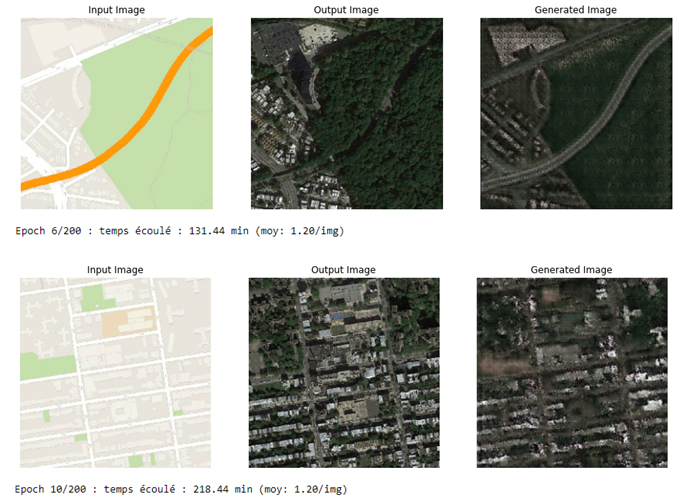

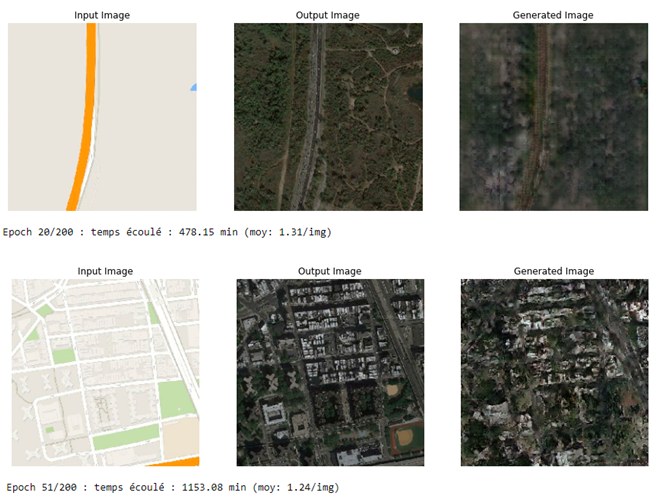

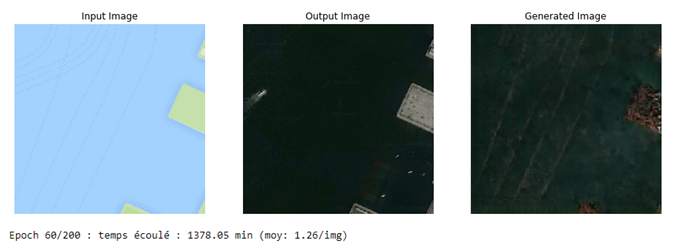

### Conclusion

Après 60 epochs, on ne voit pas le résultat final, mais on voit qu'il reconnait bien la mer, les habitations et les routes. Les images ne sont pas encore trés réalistes.  
N'ayant pas de GPU sur mon PC, je n'ai pas eu le temps de le faire tourner jusqu'à la fin. Cela va prendre plus de 4 jours, mais je le laisse tourner et vous enverrais les résultats par mail. Sans GPU, une image est traité en plus d'une seconde, alors qu'avec un GPU l'image est traité en moins de 0.10s. Donc un GPU parait nécessaire pour mener à bien ce genre de projet sans trop de souci.